In [123]:
%matplotlib inline
import pandas as pd
import sys
import numpy as np
import datetime
import seaborn as sns


In [124]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [125]:
#imports the raw data in chunks. SQL export could not accomodate one CSV dump

USMTO1 = pd.DataFrame.from_csv('USMTO1.csv', index_col = False)
USMTO2 = pd.DataFrame.from_csv('USMTO2.csv', index_col = False)
USMTO3 = pd.DataFrame.from_csv('USMTO3.csv', index_col = False)
USMTO4 = pd.DataFrame.from_csv('USMTO4.csv', index_col = False)
USMTO5 = pd.DataFrame.from_csv('USMTO5.csv', index_col = False)

In [126]:
SP_500 = pd.DataFrame.from_csv('SP_500.csv', index_col = False)

In [127]:
#re-combines raw data

USMTO_WHOLE = USMTO1.append(USMTO2).append(USMTO3).append(USMTO4).append(USMTO5)

In [128]:
USMTO_WHOLE = USMTO_WHOLE.merge(SP_500, how='inner', on = ['EntryMonth', 'EntryYear'])

In [129]:
#format order date to datetime to prepare for analysis

USMTO_WHOLE['OrderDateFormatted'] = pd.to_datetime(USMTO_WHOLE.OrderDate)

In [130]:
#format changed date to datetime to prepare for analysis

USMTO_WHOLE['ChangedDateFormatted'] = pd.to_datetime(USMTO_WHOLE.ChangedDate)

In [133]:
#format submit date to datetime to prepare for analysis

USMTO_WHOLE['SubmitDateFormatted'] = pd.to_datetime(USMTO_WHOLE.SubmitDate.fillna(''))

In [134]:
#more formatting to get Order Date at End of Month

USMTO_WHOLE['hyphen'] = "-"

USMTO_WHOLE['OrderDateEOM'] = (USMTO_WHOLE.EntryYear.astype(str)) + (USMTO_WHOLE.hyphen) + (USMTO_WHOLE.EntryMonth.astype(str)) + (USMTO_WHOLE.hyphen) + (USMTO_WHOLE.OrderDateFormatted.dt.days_in_month.astype(str))

In [135]:
#format OrderDateEOM to datetime

USMTO_WHOLE['OrderDateEOM'] = pd.to_datetime(USMTO_WHOLE['OrderDateEOM'])


In [136]:
#create column DaysLate which indicates how many days late the order was submitted

USMTO_WHOLE['DaysLate'] = (USMTO_WHOLE['SubmitDateFormatted'] - USMTO_WHOLE['OrderDateEOM']).dt.days - 10

In [137]:
#fill all NaN with "0" -> count=141

USMTO_WHOLE['DaysLate'] = USMTO_WHOLE['DaysLate'].fillna('0')

In [138]:
#cast DaysLate and TotalSale as float64

USMTO_WHOLE['DaysLate'] = pd.to_numeric(USMTO_WHOLE['DaysLate'])
USMTO_WHOLE['TotalSale'] = (USMTO_WHOLE['TotalSale'].replace( '[\$,)]','', regex=True )
               .replace( '[(]','-',   regex=True ).astype(float))

In [139]:
#drop un-needed columns

USMTO_WHOLE = USMTO_WHOLE.drop('SubmitDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('OrderDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('ChangedDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsCancel', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('CancelOrderID', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('hyphen', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsMatch', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsIgnore', axis=1)

In [140]:
#creates columns IsEmailOne, IsEmailTwo, IsCall indicating when reminders are made for a member to submit

USMTO_WHOLE['IsEmailOne'] = USMTO_WHOLE['DaysLate'] >= 1
USMTO_WHOLE.IsEmailOne = USMTO_WHOLE.IsEmailOne.astype('int')       

USMTO_WHOLE['IsEmailTwo'] = USMTO_WHOLE['DaysLate'] >= 5
USMTO_WHOLE.IsEmailTwo = USMTO_WHOLE.IsEmailTwo.astype('int')    

USMTO_WHOLE['IsCall'] = USMTO_WHOLE['DaysLate'] >= 10
USMTO_WHOLE.IsCall = USMTO_WHOLE.IsCall.astype('int')

USMTO_WHOLE['IsBackfill'] = USMTO_WHOLE['DaysLate'] >= 90
USMTO_WHOLE.IsBackfill = USMTO_WHOLE.IsBackfill.astype('int')

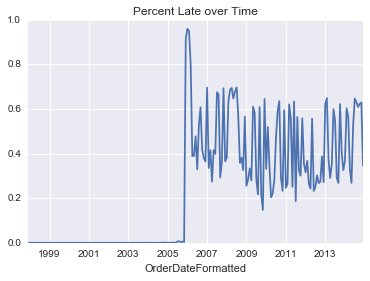

In [141]:
#shows the need to truncate data set

USMTO_WHOLE.groupby(['OrderDateFormatted'])['IsEmailOne'].mean().plot(kind = 'line', title = 'Percent Late over Time')

In [142]:
#tosses the former half of data which may not be relevant

USMTO_WHOLE = USMTO_WHOLE[(USMTO_WHOLE.OrderDateFormatted >= '2006-05-01')]

In [143]:
USMTO_WHOLE[USMTO_WHOLE.DaysLate >= 90]

,OrderID,AAID,NAICSID,CustomerZipCode,ShippingCountryID,ShippingZipCode,Units,TotalSale,CreatedBy,CreateDate,...,IP,OrderDateFormatted,ChangedDateFormatted,SubmitDateFormatted,OrderDateEOM,DaysLate,IsEmailOne,IsEmailTwo,IsCall,IsBackfill
805,d67c978f-0a9d-482f-870d-bea9826a7c47,100048,258,01810,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,38116,1,235100.0,5f086cfb-45d5-4ea2-a018-46ae6b991d3d,2/11/2014 11:51:08 AM,...,102.4621,2014-01-01,2014-02-11 11:51:08,2014-11-06 09:46:33,2014-01-31,269.0,1,1,1,1
806,cb9feb62-7586-4f84-8195-6afac2f6c9da,100048,258,01810,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,38116,1,147800.0,5f086cfb-45d5-4ea2-a018-46ae6b991d3d,2/11/2014 11:52:52 AM,...,102.4621,2014-01-01,2014-02-11 11:52:52,2014-11-06 09:46:33,2014-01-31,269.0,1,1,1,1
807,019f1f20-5135-48cd-8776-62f5a15672f8,100048,176,28273,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,28273,1,1228735.0,5f086cfb-45d5-4ea2-a018-46ae6b991d3d,2/11/2014 11:48:08 AM,...,102.4621,2014-01-01,2014-02-11 11:48:08,2014-11-06 09:46:33,2014-01-31,269.0,1,1,1,1
808,031861e8-bde0-4849-9dab-72bffb75fa6f,100048,209,37830,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,37830,1,138391.0,5f086cfb-45d5-4ea2-a018-46ae6b991d3d,2/11/2014 11:52:06 AM,...,102.4621,2014-01-01,2014-02-11 11:52:06,2014-11-06 09:46:33,2014-01-31,269.0,1,1,1,1
809,a9999f82-b3af-48e1-8e1a-afaa48601732,100048,258,01810,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,38116,1,147800.0,5f086cfb-45d5-4ea2-a018-46ae6b991d3d,2/11/2014 11:52:29 AM,...,102.4621,2014-01-01,2014-02-11 11:52:29,2014-11-06 09:46:33,2014-01-31,269.0,1,1,1,1
810,352f8576-94be-4a2f-a042-a862769d47f8,100048,209,30514,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,30512,1,141000.0,5f086cfb-45d5-4ea2-a018-46ae6b991d3d,2/11/2014 11:53:45 AM,...,102.4621,2014-01-01,2014-02-11 11:53:45,2014-11-06 09:46:33,2014-01-31,269.0,1,1,1,1
811,d5bcf631-309c-4082-aafa-8746fbf5d83e,100048,175,29305,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,29301,1,165000.0,5f086cfb-45d5-4ea2-a018-46ae6b991d3d,2/11/2014 11:47:08 AM,...,102.4621,2014-01-01,2014-02-11 11:47:08,2014-11-06 09:46:33,2014-01-31,269.0,1,1,1,1
812,e9977ea3-faed-4942-8e1b-4a423cb38eb0,100048,209,30514,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,30212,1,141000.0,5f086cfb-45d5-4ea2-a018-46ae6b991d3d,2/11/2014 11:53:19 AM,...,102.4621,2014-01-01,2014-02-11 11:53:19,2014-11-06 09:46:33,2014-01-31,269.0,1,1,1,1
813,d488a167-3423-4539-acf6-f59fac1c7522,100048,176,28273,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,28273,1,475000.0,5f086cfb-45d5-4ea2-a018-46ae6b991d3d,2/11/2014 11:48:37 AM,...,102.4621,2014-01-01,2014-11-06 09:46:18,2014-11-06 09:46:33,2014-01-31,269.0,1,1,1,1
814,376d4588-fed6-4826-aa07-f7bbf0c39c7f,100048,209,30514,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,30512,1,159000.0,5f086cfb-45d5-4ea2-a018-46ae6b991d3d,2/11/2014 11:54:07 AM,...,102.4621,2014-01-01,2014-02-11 11:54:07,2014-11-06 09:46:33,2014-01-31,269.0,1,1,1,1


In [145]:
#create two new tables, one without outliers (outside 2 stdev), and one without backfillers (defined as submitted later than 100 days - per company definition)

USMTO_NO_SUBMIT_OUTLIERS = USMTO_WHOLE[np.abs(USMTO_WHOLE.DaysLate-USMTO_WHOLE.DaysLate.mean())<=(2*USMTO_WHOLE.DaysLate.std())] 
USMTO_NO_SUBMIT_BACKFILL = USMTO_WHOLE[USMTO_WHOLE.DaysLate <= 90]

#source: http://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-dataframe


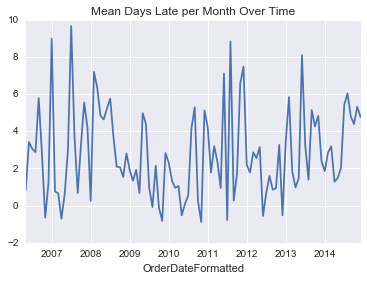

In [146]:
#Plots days late in a time series. Exhibit 1A, to be shared with team.

USMTO_NO_SUBMIT_BACKFILL.groupby(['OrderDateFormatted'])['DaysLate'].mean().plot(kind = 'line', title = 'Mean Days Late per Month Over Time')

In [147]:
#possible causes of change in oscillation
#box and whisker plots - how distribution changed over time
#change of median, edge, etc?
#potential companies that may have joined around 2005


In [148]:
#restricts Backfill table to suspicious DaysLate years

USMTO_NO_SUBMIT_BACKFILL_2005_2006 = USMTO_NO_SUBMIT_BACKFILL[USMTO_NO_SUBMIT_BACKFILL.EntryYear.between(2005,2006,inclusive = 'True')]

In [149]:
#Investigation of LateDays Spike in 2005. Exhibit 1B, to be shared with team.

USMTO_NO_SUBMIT_BACKFILL_2005_2006.groupby(['EntryYear','EntryMonth'])['DaysLate'].mean()

EntryYear  EntryMonth
2006       5             0.811528
           6             3.415195
           7             3.057385
           8             2.874966
           9             5.782066
           10            2.791005
           11           -0.653747
           12            1.196773
Name: DaysLate, dtype: float64

In [150]:
#Further investigation into Dec 2005 to March 2006

USMTO_NO_SUBMIT_BACKFILL_2005_2006_RESTRICT = USMTO_NO_SUBMIT_BACKFILL[USMTO_NO_SUBMIT_BACKFILL.OrderDateFormatted.between('2005-12-01','2006-03-01',inclusive = 'True')]
Export = USMTO_NO_SUBMIT_BACKFILL_2005_2006_RESTRICT.groupby(['EntryYear','EntryMonth','AAID'])['DaysLate'].mean()
Export.to_csv('Suspicious Records 2005-2006')

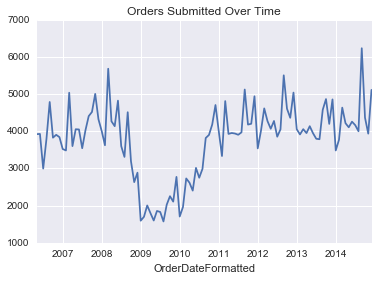

In [151]:
#plot order submission trend. Exhibit 2

USMTO_WHOLE.groupby(['OrderDateFormatted'])['IsSubmitted'].sum().plot(kind = 'line', title = 'Orders Submitted Over Time')

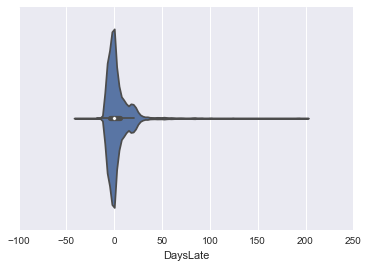

In [152]:
#plots distribution of days late

sns.violinplot(USMTO_NO_SUBMIT_OUTLIERS.DaysLate, title = 'Distribution of Days Late, 1997 to present')


In [180]:
#Creates table by AAID and OrderDateFormatted

AAID_BY_MONTH = USMTO_WHOLE.groupby(['AAID','OrderDateFormatted'])['DaysLate','TotalSale','IsEmailOne', 'IsEmailTwo', 'IsCall', 'IsBackfill','Close','IP'].mean()
AAID_BY_MONTH.reset_index(level=1, inplace=True)
AAID_BY_MONTH.reset_index(level=1, inplace=True)
AAID_BY_MONTH_2 = USMTO_WHOLE.groupby(['AAID','OrderDateFormatted'])['Units','TotalSale'].sum()
AAID_BY_MONTH_2.reset_index(level=1, inplace=True)
AAID_BY_MONTH_2.reset_index(level=1, inplace=True)
AAID_BY_MONTH = AAID_BY_MONTH.merge(AAID_BY_MONTH_2, how = 'inner', on = ['AAID','OrderDateFormatted'])
AAID_BY_MONTH['TotalSaleAvg'] = AAID_BY_MONTH['TotalSale_x']
AAID_BY_MONTH['TotalSale'] = AAID_BY_MONTH['TotalSale_y']
AAID_BY_MONTH = AAID_BY_MONTH.drop('TotalSale_x', axis = 1)
AAID_BY_MONTH = AAID_BY_MONTH.drop('TotalSale_y', axis = 1)
AAID_BY_MONTH

,AAID,OrderDateFormatted,DaysLate,IsEmailOne,IsEmailTwo,IsCall,IsBackfill,Close,IP,Units,TotalSaleAvg,TotalSale
0,123,2007-12-01,522.0,1,1,1,1,1468.359985,105.7256,13,1.846154e+04,240000.00
1,123,2010-10-01,673.0,1,1,1,1,1183.260010,95.6362,2,1.000000e+05,200000.00
2,100005,2006-05-01,-5.0,0,0,0,0,1270.089966,102.1531,7,1.314387e+05,920071.00
3,100005,2006-06-01,1.0,1,0,0,0,1270.199951,102.5220,2,1.539455e+05,307891.00
4,100005,2006-07-01,-8.0,0,0,0,0,1276.660034,102.5057,11,5.797109e+04,637682.00
5,100005,2006-08-01,15.0,1,1,1,0,1303.819946,102.8357,1,6.599400e+04,65994.00
6,100005,2006-10-01,3.0,1,0,0,0,1377.939941,102.6297,1,1.063480e+05,106348.00
7,100005,2006-11-01,-3.0,0,0,0,0,1400.630005,102.5390,15,1.291431e+05,1937146.00
8,100005,2006-12-01,-7.0,0,0,0,0,1418.300049,103.6229,1,6.636000e+04,66360.00
9,100005,2007-01-01,-9.0,0,0,0,0,1438.239990,103.1171,4,1.997450e+04,79898.01


In [190]:
#gets rid of all observations that are backfills
AAID_BY_MONTH_NO_BACKFILL = AAID_BY_MONTH[AAID_BY_MONTH.DaysLate <= 90]


In [205]:
#NOOB MOVE LOL

AAID_BY_MONTH_NO_BACKFILL.to_csv('AAID By Month')
AAID_BY_MONTH_NO_BACKFILL = pd.DataFrame.from_csv('AAID By Month Edited.csv', index_col = False)
AAID_BY_MONTH_NO_BACKFILL['DaysLateLastThree'] = pd.to_numeric(AAID_BY_MONTH_NO_BACKFILL['DaysLateLastThree'])
AAID_BY_MONTH_NO_BACKFILL['TotalSaleLastThree'] = pd.to_numeric(AAID_BY_MONTH_NO_BACKFILL['TotalSaleLastThree'])
AAID_BY_MONTH_NO_BACKFILL = AAID_BY_MONTH_NO_BACKFILL.fillna(value = 0)


In [192]:
AAID_BY_MONTH_NO_BACKFILL.dtypes

AAID                      int64
OrderDateFormatted       object
DaysLate                  int64
IsEmailOne                int64
IsEmailTwo                int64
IsCall                    int64
IsBackfill                int64
Close                   float64
Units                     int64
TotalSaleAvg            float64
TotalSale               float64
Three_MMA_Late          float64
Three_MMA_SalesTrend    float64
DaysLateLastThree       float64
TotalSaleLastThree      float64
DaysLateLast            float64
IP                      float64
dtype: object

In [193]:
#create column "Three MMA Late" - which models the average of the past three month's lateness for each company

#AAID_BY_MONTH_NO_BACKFILL['Three_MMA_Late'] = AAID_BY_MONTH_NO_BACKFILL.DaysLate.ewm(span=3).mean()
#AAID_BY_MONTH_NO_BACKFILL.groupby(['OrderDateFormatted'])['Three_MMA_Late'].mean().plot(kind = 'line')


In [194]:
#AAID_BY_MONTH_NO_BACKFILL['Three_MMA_SalesTrend'] = AAID_BY_MONTH_NO_BACKFILL.TotalSale.ewm(span=3).mean()
#AAID_BY_MONTH_NO_BACKFILL.groupby(['OrderDateFormatted'])['Three_MMA_SalesTrend'].sum().plot(kind = 'line')

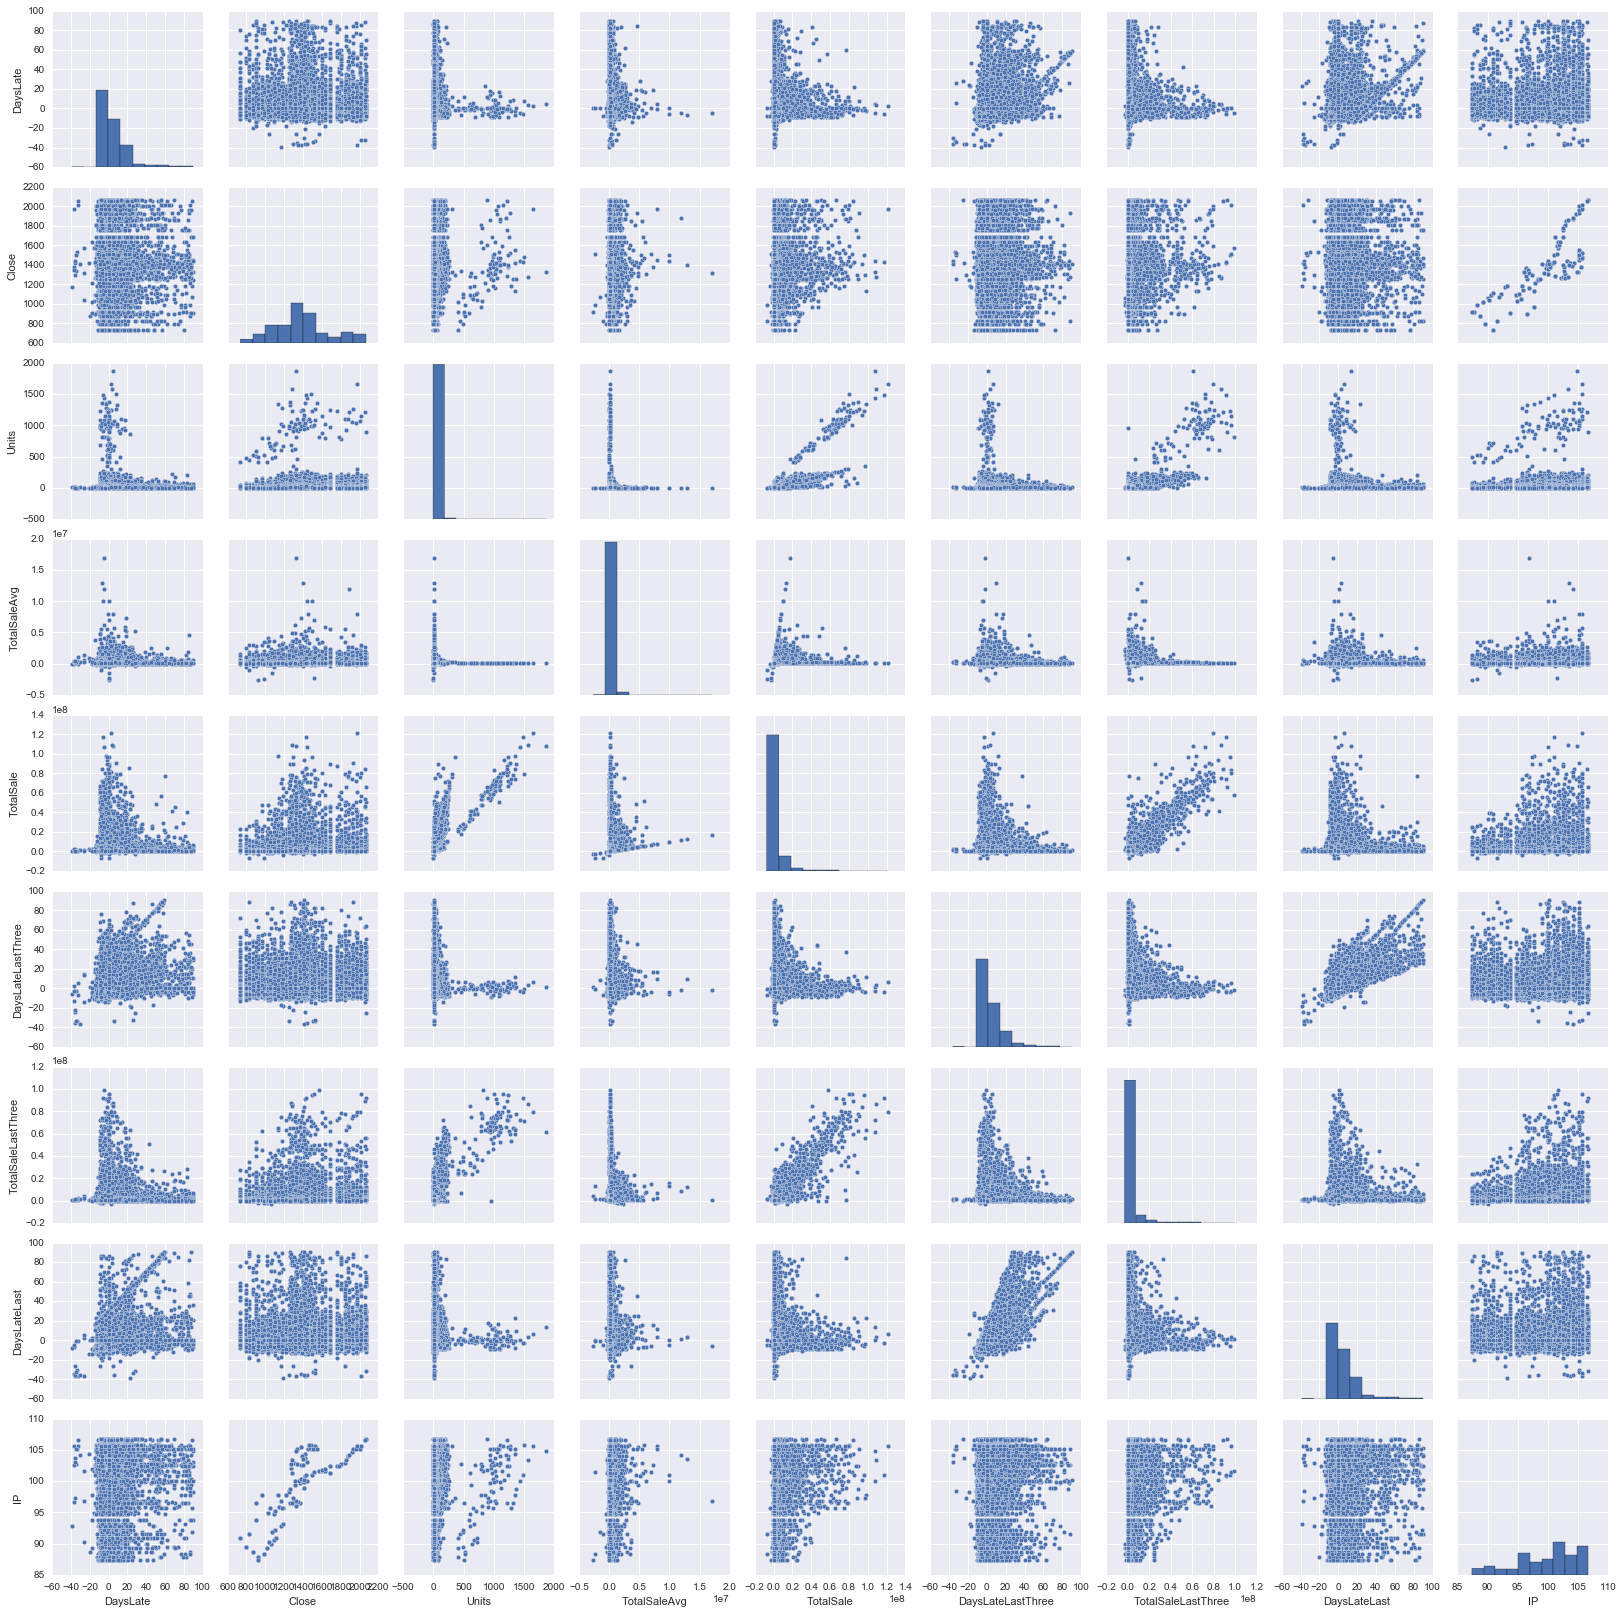

In [195]:
#scatter matrix identifying key features - target excluded

PAIRPLOT = AAID_BY_MONTH_NO_BACKFILL
PAIRPLOT = PAIRPLOT.drop('AAID', axis = 1)
PAIRPLOT = PAIRPLOT.drop('OrderDateFormatted', axis = 1)
PAIRPLOT = PAIRPLOT.drop('IsEmailOne', axis = 1)
PAIRPLOT = PAIRPLOT.drop('IsEmailTwo', axis = 1)
PAIRPLOT = PAIRPLOT.drop('IsCall', axis = 1)
PAIRPLOT = PAIRPLOT.drop('IsBackfill', axis = 1)
PAIRPLOT = PAIRPLOT.drop('Three_MMA_Late', axis = 1)
PAIRPLOT = PAIRPLOT.drop('Three_MMA_SalesTrend', axis = 1)

sns.pairplot(PAIRPLOT)

In [213]:
#prep for correlation matrix - target included

PAIRPLOT2 = AAID_BY_MONTH_NO_BACKFILL
PAIRPLOT2 = PAIRPLOT2.drop('AAID', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('OrderDateFormatted', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailOne', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailTwo', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsBackfill', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('Units', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('DaysLate', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('Three_MMA_Late', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('Three_MMA_SalesTrend', axis = 1)

corr2 = PAIRPLOT2.corr(method = 'pearson')

In [214]:
#Class Distribution

AAID_BY_MONTH_NO_BACKFILL.groupby('IsCall').size()

IsCall
0    12321
1     3719
dtype: int64

In [215]:
#Correlations between Attributes

corr = PAIRPLOT.corr(method = 'pearson')

In [216]:
#Skew of Attributes

PAIRPLOT.skew()

DaysLate               2.466051
Close                  0.369165
Units                 11.854637
TotalSaleAvg          12.365677
TotalSale              6.010543
DaysLateLastThree      2.282733
TotalSaleLastThree     5.921147
DaysLateLast           2.516090
IP                    -0.724223
dtype: float64

In [217]:
PAIRPLOT2.corr()

,IsCall,Close,TotalSaleAvg,TotalSale,DaysLateLastThree,TotalSaleLastThree,DaysLateLast,IP
IsCall,1.000000,0.077764,0.027854,-0.001683,0.468462,-0.008314,0.449449,0.122950
Close,0.077764,1.000000,0.028971,0.065513,0.055842,0.063490,0.060961,0.789642
TotalSaleAvg,0.027854,0.028971,1.000000,0.142124,0.029665,0.084622,0.025975,0.035300
TotalSale,-0.001683,0.065513,0.142124,1.000000,-0.005230,0.897373,0.002898,0.079643
DaysLateLastThree,0.468462,0.055842,0.029665,-0.005230,1.000000,0.000267,0.805163,0.100742
TotalSaleLastThree,-0.008314,0.063490,0.084622,0.897373,0.000267,1.000000,0.002879,0.080763
DaysLateLast,0.449449,0.060961,0.025975,0.002898,0.805163,0.002879,1.000000,0.095675
IP,0.122950,0.789642,0.035300,0.079643,0.100742,0.080763,0.095675,1.000000


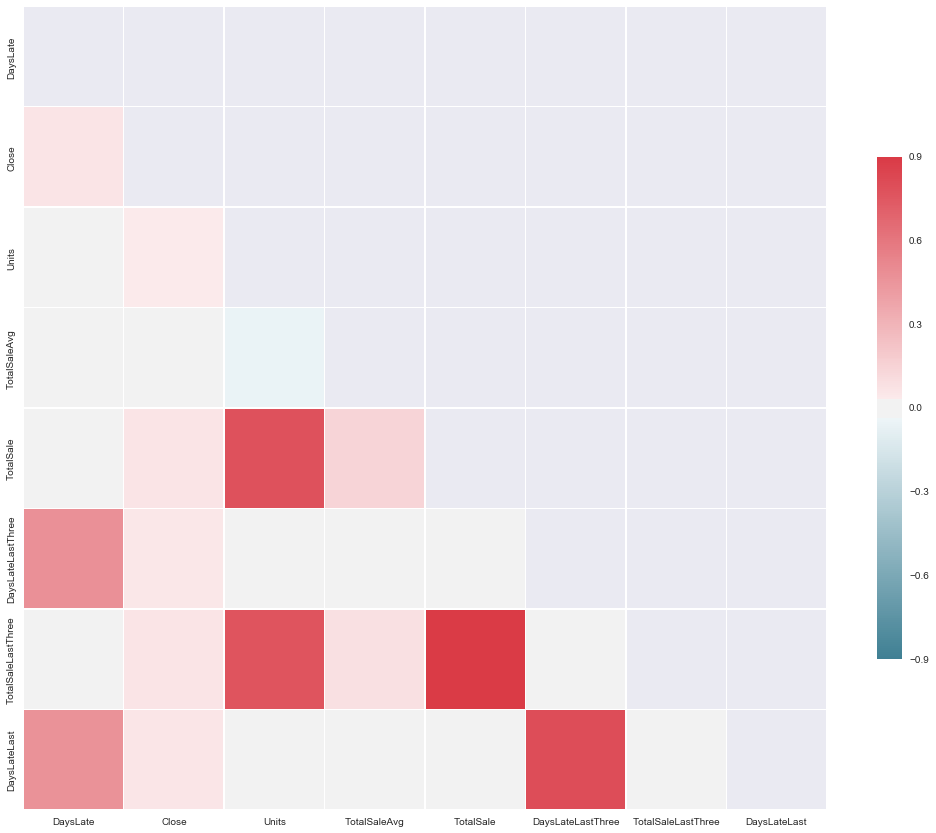

In [206]:
#Correlation Matrix Plot
import matplotlib.pyplot as plt

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18,18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)


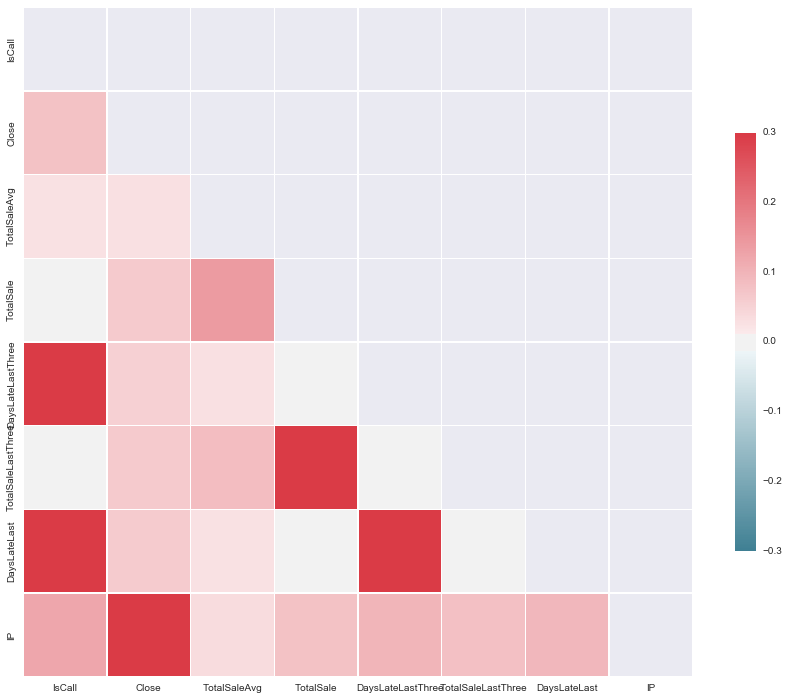

In [218]:
#Correlation Matrix Plot
import matplotlib.pyplot as plt

# Generate a mask for the upper triangle
mask = np.zeros_like(corr2, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15,15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr2, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)


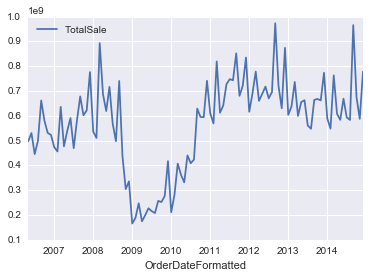

In [165]:
#average sales over time

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).sum()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='TotalSale')

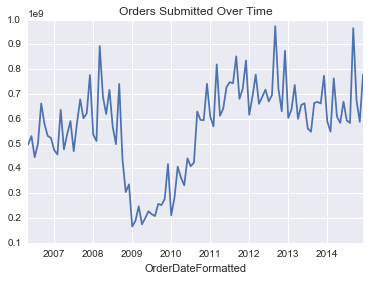

In [166]:
#plot of orders submitted over time

USMTO_WHOLE.groupby(['OrderDateFormatted'])['TotalSale'].sum().plot(kind = 'line', title = 'Orders Submitted Over Time')

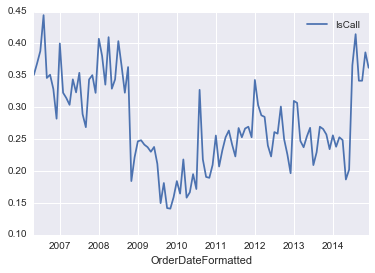

In [167]:
#percentage of company by month who needed to be called

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsCall')

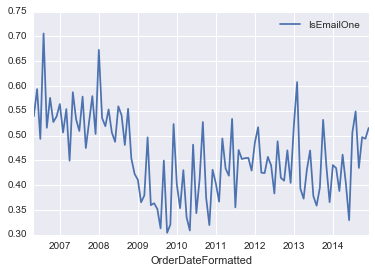

In [168]:
#percentage of company by month who needed to have first email sent

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsEmailOne')

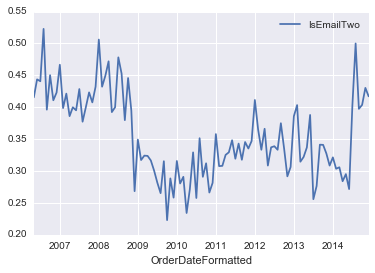

In [169]:
#percentage of company by month who needed to have second email sent

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsEmailTwo')

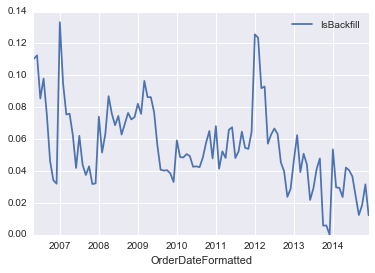

In [170]:
#percentage of company by month who backfilled

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsBackfill')

In [172]:
#APPENDIX AS FOLLOWS: (works in progress)

In [173]:
#cols to create:

#3 MMA company sales
#3 MMA lateness
# s&p 500 
machine tool mix
#prior month late days
# scatter matrix



SyntaxError: invalid syntax (<ipython-input-173-8bd383b2e483>, line 6)

In [ ]:
#attempts to map which AAIDs submitted over what dates

AAIDs = pd.DataFrame.from_csv('AAIDs.csv', index_col = False)

In [ ]:
AAIDs = AAIDs.fillna('')

In [ ]:
AAIDs

In [ ]:
#plots distribution who received a first email, over all time

USMTO_WHOLE.groupby('OrderDateFormatted')['IsEmailOne'].mean().plot(kind = 'hist',bins = 10)

In [ ]:
USMTO_WHOLE.groupby('OrderDateFormatted')['IsEmailTwo'].mean().plot(kind = 'hist',bins = 10)

In [ ]:
USMTO_WHOLE.groupby('OrderDateFormatted')['IsCall'].mean().plot(kind = 'hist',bins = 10)

In [ ]:
USMTO_WHOLE.groupby('OrderDateFormatted')['IsBackfill'].mean().plot(kind = 'hist',bins = 10)

In [ ]:
USMTO_WHOLE